In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm
import pickle

from open_ephys.analysis import Session
import pyopenephys as oe

from utils import plot_lfp, evoked_response_potential, butter_bandstop_filter, get_channel_idx, get_brain_region

### Data loading

In [2]:
#load data
DATA_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10"
EXP_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10/Record Node 107/"
session = Session(DATA_FOLDER)

info = session.recordnodes[0].recordings[0].info['continuous'][0]
Fs = info['sample_rate']
channels = info['channels']
channel_names = [c['channel_name'] for c in channels]
unique_channel_names = np.unique(channel_names)
unique_data_channel_names = np.unique(channel_names[0:127])
brain_regions = ["A1T", "BLAT", "HPCT", "PFCT"]


# cannot load data via session (permission denied)
# samples = session.recordnodes[0].recordings[0].continuous[0].samples

data_file = oe.File(EXP_FOLDER)
experiments = data_file.experiments

experiment = experiments[0]
recordings = experiment.recordings

rec1 = recordings[0]
rec2 = recordings[1]

signal = rec1.analog_signals[0].signal
ts = np.asarray(rec1.analog_signals[0].times)


Loading Open-Ephys: reading settings...
Decoding data from  binary  format
Reading oebin file
Reading oebin file


In [3]:
del(session)

### Downsampling and filtering

In [4]:
fs_target = 1000
ds_factor = Fs // fs_target
ds_length = signal.shape[1] // ds_factor

downsampled_signal = np.empty((signal.shape[0], ds_length))
downsampled_ts = np.empty(ds_length)

for idx in range(ds_length):
    downsampled_signal[:, idx] = signal[:, idx * ds_factor] 
    downsampled_ts[idx] = ts[idx * ds_factor]


In [5]:
filtered_signal = butter_bandstop_filter(downsampled_signal, lowcut=48, highcut=51, fs=fs_target, order=5)

### Save data

Can't do it, array too large and not enough memory

### Get stimuli occurences

In [32]:
# each stimulus is defined by a peak in the ADC channels with a minimum gap of 1 second between them
CSmin_idx = sig.find_peaks(downsampled_signal[144], distance=1000, prominence=10000)[0]
CSplus_idx = sig.find_peaks(downsampled_signal[145], distance=1000, prominence=10000)[0]
CSnovel_idx = sig.find_peaks(downsampled_signal[143], distance=1000, prominence=10000)[0]

In [33]:
print(CSmin_idx)

[200965 202963 203963 404031 406030 611110 612110 614108 848184 850182
 851182 987256 989254 990254]


### Plot ERPs

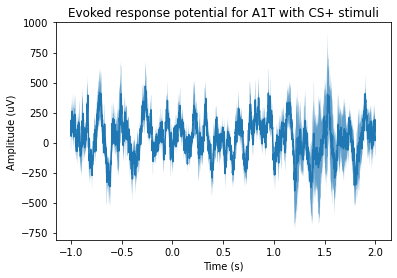

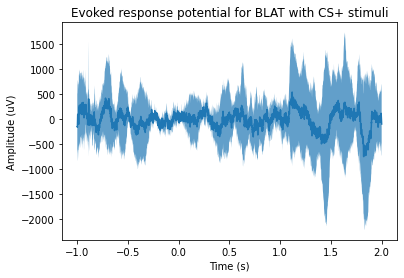

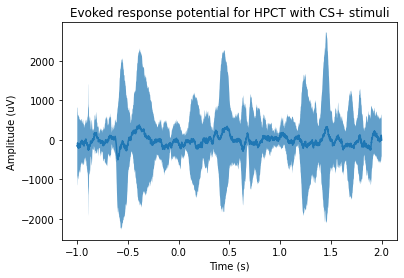

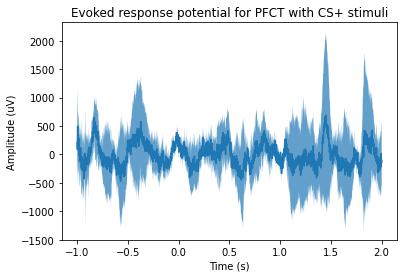

In [34]:
for br in brain_regions:
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        responses.append(evoked_response_potential(filtered_signal, CSplus_idx, channels, -1, 2, num_stimuli=0, plot=False))
    responses = np.vstack(responses)

    std = np.std(responses, axis=0)
    y_mean = np.mean(responses, axis=0)

    plt.fill_between(np.linspace(-1, 2, responses.shape[1]), y_mean - std, y_mean + std, alpha=0.7)
    plt.plot(np.linspace(-1, 2, responses.shape[1]), y_mean)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.title(f"Evoked response potential for {br} with CS+ stimuli")
    plt.show()

    
    
    

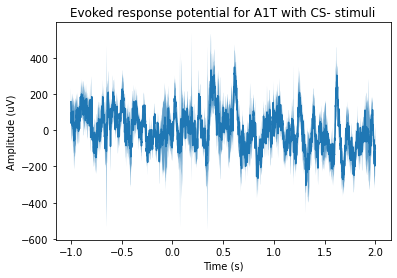

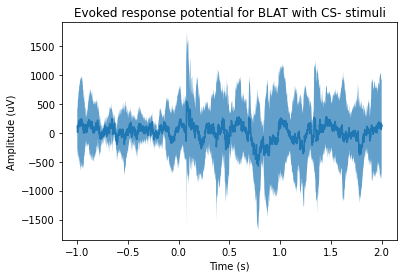

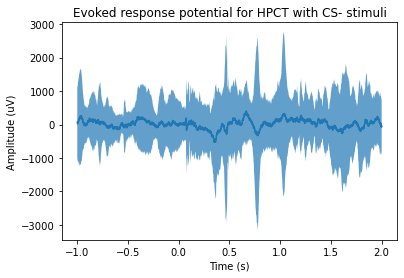

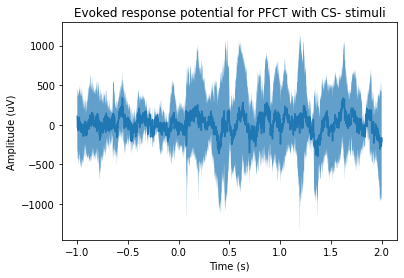

In [37]:
for br in brain_regions:
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        responses.append(evoked_response_potential(filtered_signal, CSmin_idx, channels, -1, 2, num_stimuli=0, plot=False))
    responses = np.vstack(responses)

    std = np.std(responses, axis=0)
    y_mean = np.mean(responses, axis=0)

    plt.fill_between(np.linspace(-1, 2, responses.shape[1]), y_mean - std, y_mean + std, alpha=0.7)
    plt.plot(np.linspace(-1, 2, responses.shape[1]), y_mean)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.title(f"Evoked response potential for {br} with CS- stimuli")
    plt.show()

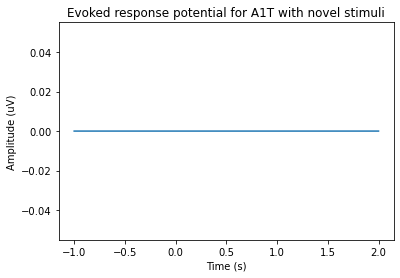

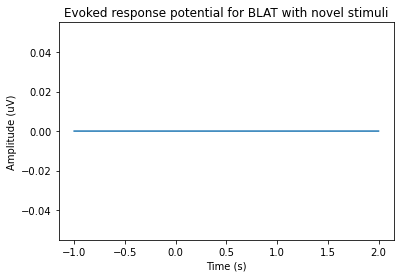

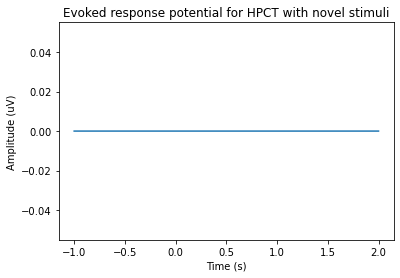

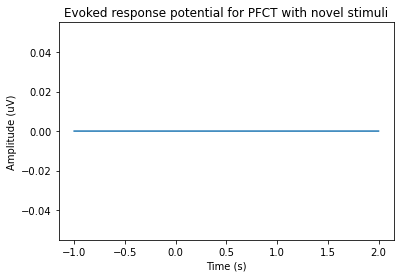

In [36]:
for br in brain_regions:
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        responses.append(evoked_response_potential(filtered_signal, CSnovel_idx, channels, -1, 2, num_stimuli=0, plot=False))
    responses = np.vstack(responses)

    std = np.std(responses, axis=0)
    y_mean = np.mean(responses, axis=0)

    plt.fill_between(np.linspace(-1, 2, responses.shape[1]), y_mean - std, y_mean + std, alpha=0.7)
    plt.plot(np.linspace(-1, 2, responses.shape[1]), y_mean)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.title(f"Evoked response potential for {br} with novel stimuli")
    plt.show()

In [116]:
def plot_lfp(eeg_data, ts, start, duration, channels, color='k'):
    """
    Plot EEG data vertically.

    Parameters
    ----------
    eeg_data : ndarray
        EEG data.
    ts : ndarray
        Timestamps.
    start : float
        Time in seconds to start plotting.
    duration : float
        Duration in seconds to plot from start.
    channels : list
        List of channels to plot.
    color : str
        Color of the lines.
    """

    # find the start and end indices in timestamps array
    start_idx = np.argmin(np.abs(ts - start))
    end_idx = np.argmin(np.abs(ts - (start + duration)))

    # find maximum voltage to space the channels in the plot
    spacing = np.amax(abs(eeg_data[channels, start_idx:end_idx])) * 2
    
    plt.plot(ts[start_idx:end_idx], eeg_data[channels, start_idx:end_idx].T + spacing * np.arange(len(channels) - 1, -1, -1))

    plt.yticks(spacing * np.arange(len(channels) - 1, -1, -1), [f"Channel {i}" for i in channels])
    plt.xlabel("Time (s)")
    plt.ylabel("Channels")
    plt.show()

A1T11 [40, 41, 42, 43]


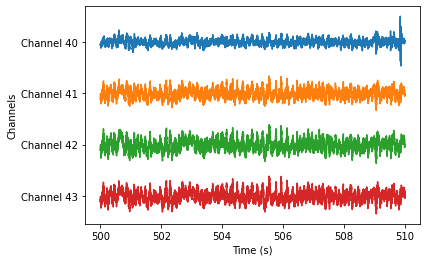

A1T12 [44, 45, 46, 47]


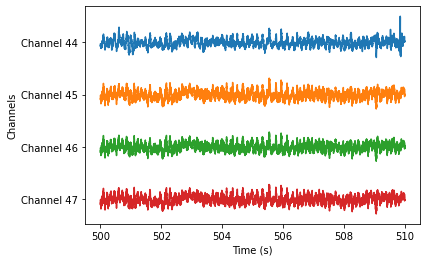

A1T13 [48, 49, 50, 51]


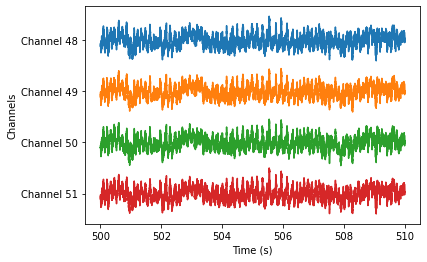

A1T14 [52, 53, 54, 55]


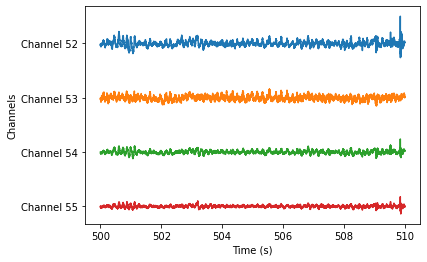

A1T15 [56, 57, 58, 59]


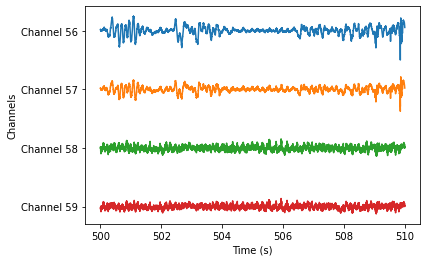

A1T16 [60, 61, 62, 63]


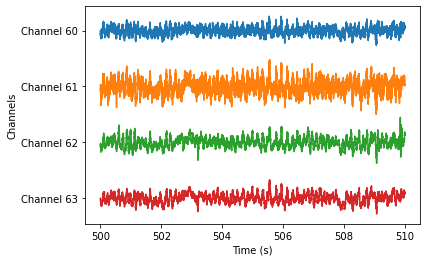

A1T17 [32, 33, 34, 35]


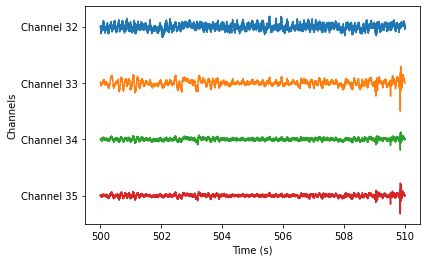

A1T9 [24, 25, 26, 27]


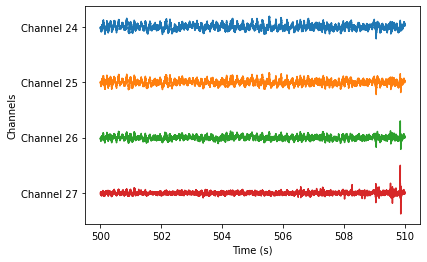

BLAT27 [104, 105, 106, 107]


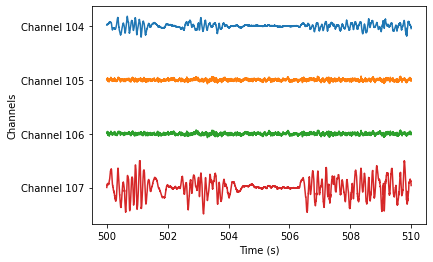

BLAT29 [88, 89, 90, 91]


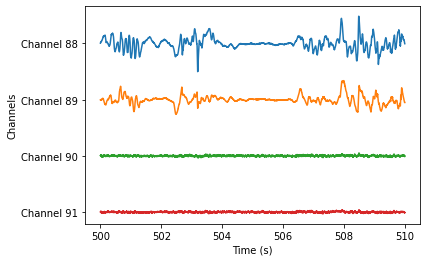

BLAT30 [92, 93, 94, 95]


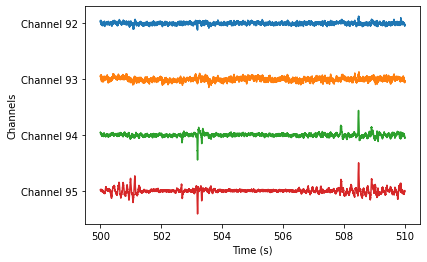

BLAT31 [64, 65, 66, 67]


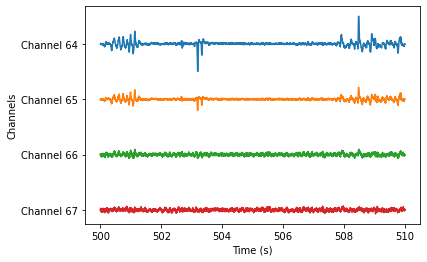

BLAT32 [68, 69, 70, 71]


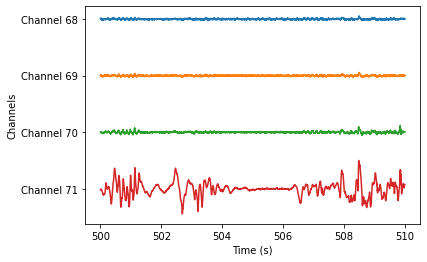

BLAT33 [72, 73, 74, 75]


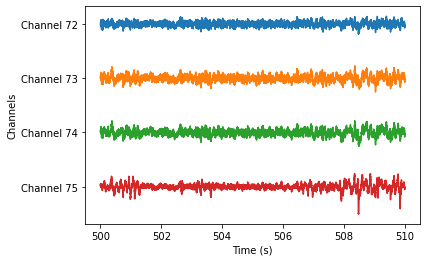

BLAT34 [76, 77, 78, 79]


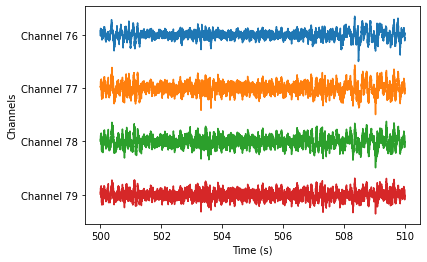

BLAT35 [80, 81, 82, 83]


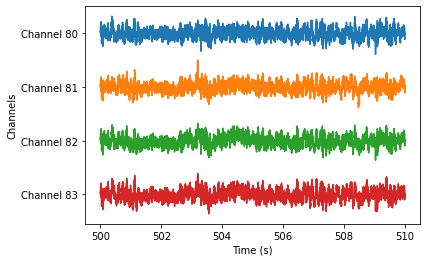

HPCT18 [36, 37, 38, 39]


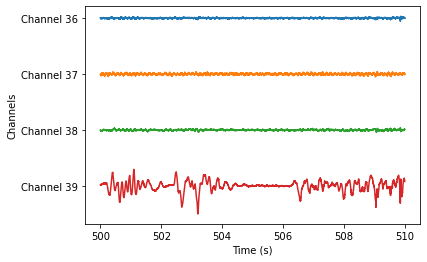

HPCT20 [116, 117, 118, 119]


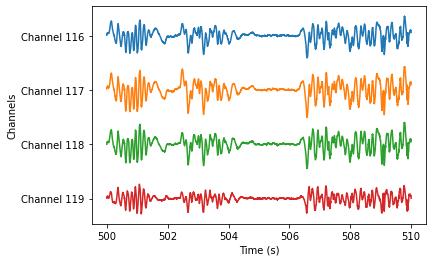

HPCT21 [120, 121, 122, 123]


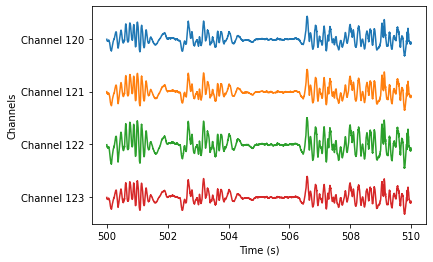

HPCT22 [124, 125, 126, 127]


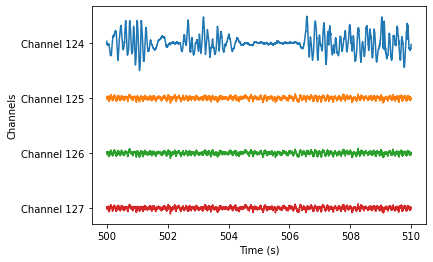

HPCT23 [112, 113, 114, 115]


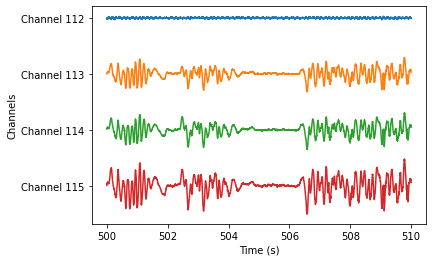

HPCT24 [108, 109, 110, 111]


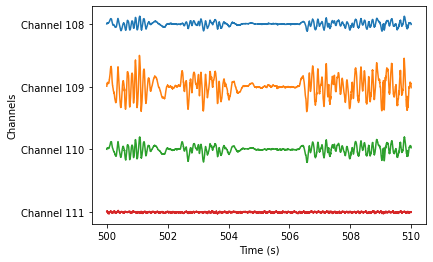

HPCT25 [96, 97, 98, 99]


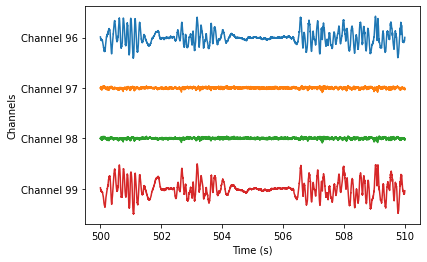

HPCT26 [100, 101, 102, 103]


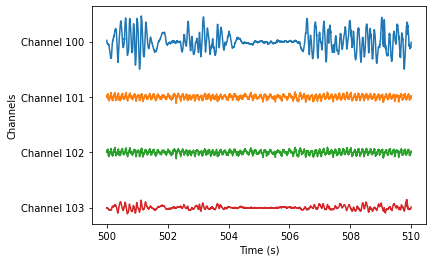

PFCT2 [4, 5, 6, 7]


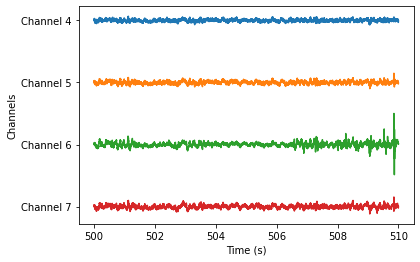

PFCT3 [8, 9, 10, 11]


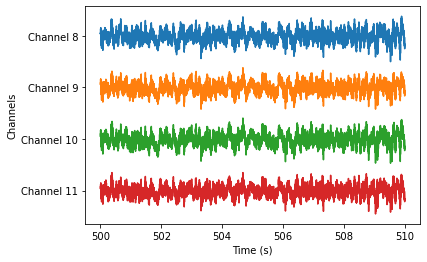

PFCT36 [84, 85, 86, 87]


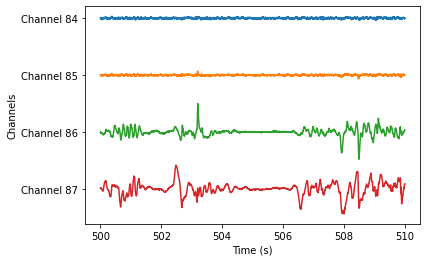

PFCT4 [12, 13, 14, 15]


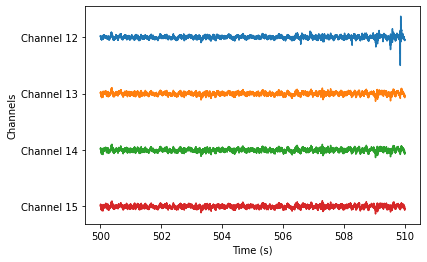

PFCT5 [0, 1, 2, 3]


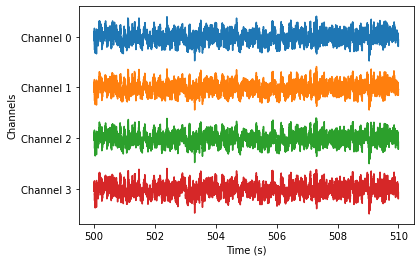

PFCT6 [28]


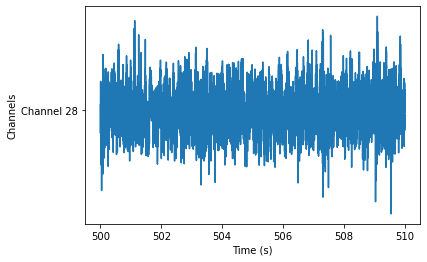

PFCT7 [16, 17, 18, 19]


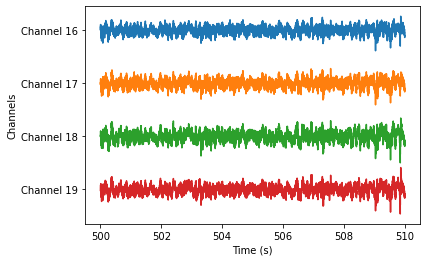

PFCT8 [20, 21, 22, 23, 29, 30, 31]


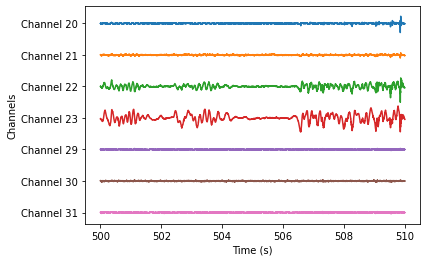

In [118]:
for br in brain_regions:
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        print(trode, channels)
        plot_lfp(filtered_signal, downsampled_ts, 500, 10, channels)